#### Assignment 4 - 158.755 - S01 2021
##### James Bristow - 11189075
##### Martin Brenner - 20022611
***
<center><h1>Dolphin Photo-Identification</h1><h3>Identification of individual dolphins based on their dorsal fin</h3></center>

## Abstract
In this report we obtain we document how we identify individual dolphins based on their dorsal fin.<br> For this task a system was designed that can take a photo, showing dorsal fins, as input and produce a prediction of which individual can be seen on the photo. For the fin detection process a YOLOv4 network was trained to detect the fins. In a second step the fin is being cropped from the image and put through some pre-processing to enhance features. For the identification of the individual a Triplet Loss Neural Network was configured. The network was trained on a cleaned and labelled data set of individual dolphin fins.<br> UMAP is used to visualise the network performance and clusters of individuals based on the training data set.<br> A software solution combining all steps was produced using the Flask server which enables the user to upload a batch of photos which are then put through the identification process.

## Introduction
The identification of individual dolphins is of relevance to researchers who want to distinguish and catalog them for study purposes. The task of matching individuals by visual comparison is time consuming why we propose a system that can aide in the identification by applying neural networks.


## 1. Fin detection using YOLO
YOLO was chosen as it is one of the most advanced single shot decoders for object detection available at the time.<br> The data was prepared in a directory including the required bounding box definitions.
### 1.1 Training the model

In [1]:
# Imports 
import os
import random
import shutil
from glob import glob
import matplotlib.pyplot as plt

# Constants
SEED = 100
TEST_PROP =  0.15

In [2]:
IMAGES_DIR = '../images'
MODEL_DIR = '../models/darknet'
data_dir = IMAGES_DIR + "/NDD20/"
file_dir = f"{data_dir}data/"
files = glob(f'{file_dir}*.jpg')

Check for the files:

In [3]:
files[0:5]

['../images/NDD20/data\\0.jpg',
 '../images/NDD20/data\\1.jpg',
 '../images/NDD20/data\\10.jpg',
 '../images/NDD20/data\\100.jpg',
 '../images/NDD20/data\\1000.jpg']

Next, the files will be shuffled and split into the training and testing set. An 85-15 split is used. From the DarkNet documentation, we want around at least 2000 training objects per class.

In [4]:
def test_train_split(files, test_prop = 0.1):
    list_size = int(round(test_prop * len(files)))
    shuffled = files[:]
    random.seed(SEED)
    random.shuffle(shuffled)
    return shuffled[list_size:], shuffled[:list_size]

def to_relative_path(full_path_list):
  relative_path_list = []

  for file in full_path_list:
    split_file = file.split("/")
    relative_path = f'{split_file[-2]}/{split_file[-1]}'
    relative_path_list.append(relative_path)
    return relative_path_list

In [5]:
train, test = test_train_split(files, TEST_PROP)
print(f"Train length: {len(train)}\nTest length: {len(test)}\nTotal: {len(files)}")

Train length: 1871
Test length: 330
Total: 2201


The lists of train and test file names will be written to train.txt and test.txt respectively.

In [6]:
if not os.path.exists('./tmp'):
    os.mkdir('./tmp')
with open("./tmp/train.txt", "w") as outfile:
    outfile.write("\n".join(train))

with open("./tmp/test.txt", "w") as outfile:
    outfile.write("\n".join(test))

shutil.move("./tmp/train.txt", data_dir + "train.txt")
shutil.move("./tmp/test.txt", data_dir + "test.txt")

'../images/NDD20/test.txt'

DarkNet needs to be compiled, and GPU support must be enabled.
Below commands have been executed in a COLAB environment and can not be run locally unless an environment is prepared why it is not presented as executable code.

<code>%cd /proj/MyDrive/DolphinClassification/neural_nets/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

!make

%env IMAGES_DIR=/content/NDD20
%env MODEL_DIR=/proj/MyDrive/DolphinClassification/models/darknet
#### Next, we'll begin the training process.
! chmod +x ./darknet
! chmod +rwx /proj/MyDrive/DolphinClassification/models/darknet/training
! ./darknet detector train ${IMAGES_DIR}/obj.data ${MODEL_DIR}/yolov4-dolphin.cfg ${MODEL_DIR}/yolov4.conv.137 -dont_show -map
! ./darknet detector train ${IMAGES_DIR}/obj.data ${MODEL_DIR}/yolov4-dolphin.cfg ${MODEL_DIR}/training/yolov4-dolphin_last.weights -dont_show -map

----------------------------------------------------------------------
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
...
----------------------------------------------------------------------
<b>detections_count = 3177, unique_truth_count = 2763  
class_id = 0, name = dolphin, ap = 98.83%   	 (TP = 2735, FP = 67) 

 for conf_thresh = 0.10, precision = 0.98, recall = 0.99, F1-score = 0.98 
 for conf_thresh = 0.10, TP = 2735, FP = 67, FN = 28, average IoU = 77.02 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.988323, or 98.83 % 
Total Detection Time: 243 Seconds</b>
</code>

After the training finished we have a configuration and weights file to work with a darknet detector.
### 1.2 Detector
The OpenCV implementation of cv2.dnn.readNetFromDarknet is being used for the detection process which is implemented as the find_fin function in the feature_extract.py file.

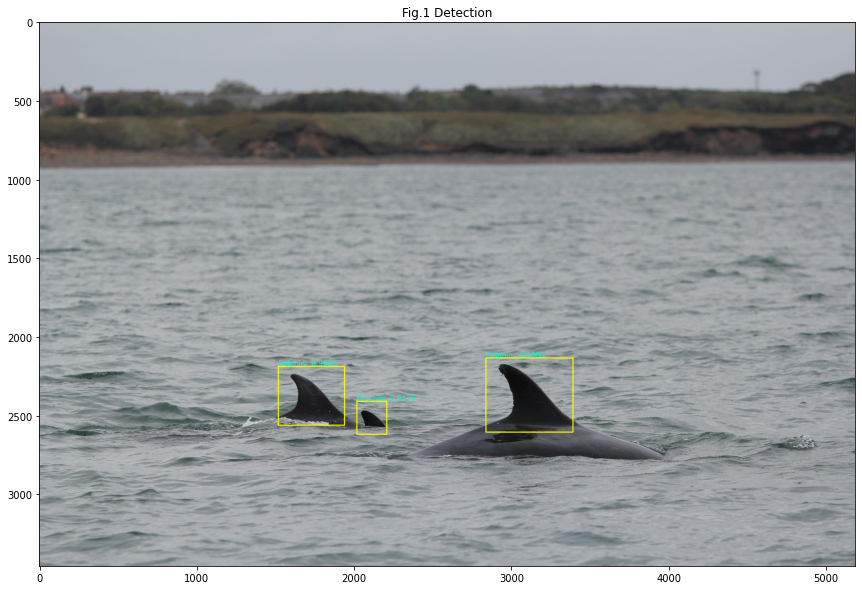

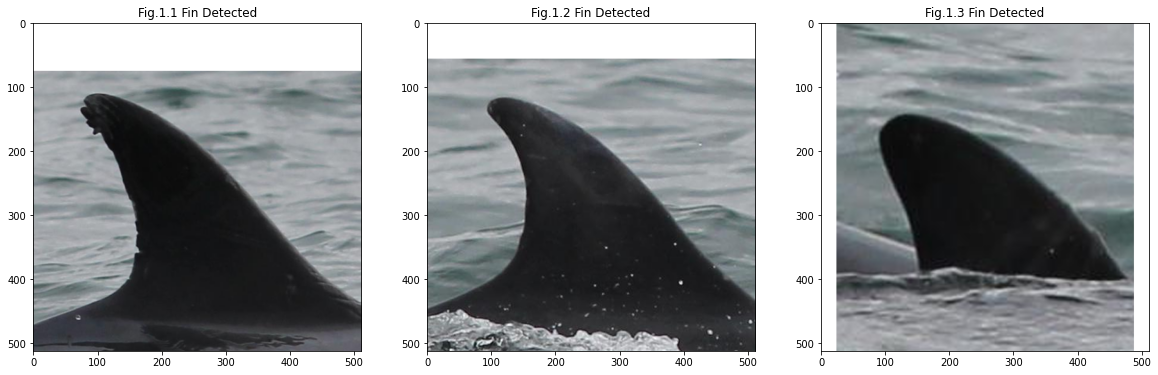

In [7]:
from feature_extract import *
import cv2
IMG_SIZE = 512

image = cv2.imread(data_dir+"/data/9.jpg")

CONFIDENCE = 0.5
THRESHOLD = 0.5    
weightsPath = os.path.sep.join([MODEL_DIR, "training/yolov4-dolphin_best.weights"])
configPath = os.path.sep.join([MODEL_DIR, "yolov4-dolphin.cfg"])
    
images, img_find = find_fin(image,weightsPath,configPath,CONFIDENCE,THRESHOLD,IMG_SIZE,255)

# number of fins found
#print(len(images))
plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(img_find, cv2.COLOR_BGR2RGB)); plt.title("Fig.1 Detection");
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(images[0][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.1.1 Fin Detected");
plt.subplot(132)
plt.imshow(cv2.cvtColor(images[1][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.1.2 Fin Detected");
plt.subplot(133)
plt.imshow(cv2.cvtColor(images[2][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.1.3 Fin Detected");


The first image above show the input image with the detection bounding boxes of the fins found. The function includes the cropping, resizing and padding of the found fins to produce equally sized images.

## 2. Image Pre-Processing
We further process the found images to emphasise features. This process is applied to training data as well as the input data in the final matching process.

### 2.1 Training data
A set of training data is available in the form of labelled fins with the background removed. For some of the images the pixel data behind the 4th channel(alpha channel), which is a transparency map, have to be removed as only 3 channels (RGB/BGR) are being processed. A function for this was implemented in the file feature_extract.py.

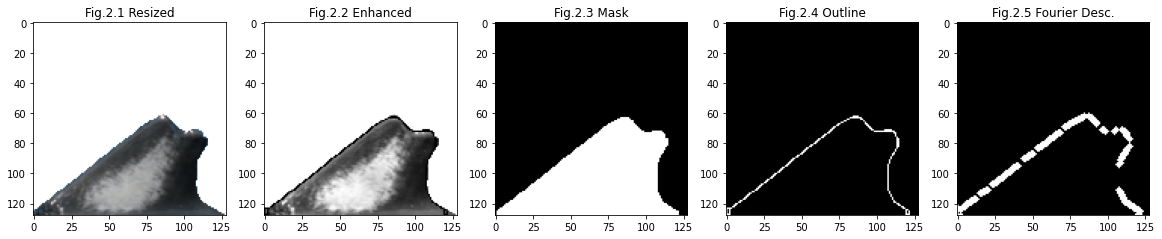

In [8]:
from feature_extract import *
IMG_SIZE = 128
IMAGES_DIR = '../images/final_pigmentation_catalogue_2016'
TARGET_IMAGES_DIR = '../images/fin_features_'+str(IMG_SIZE)

image_x = cv2.imread(IMAGES_DIR+"/0002/HG_100429_011_SD.png", cv2.IMREAD_UNCHANGED) # read alpha channel
#image_x = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
img_rsz, img_ftr, img_mask, img_cntr, img_fd, fourier_desc, status = feature_extract(image_x, IMG_SIZE)
plt.figure(figsize=(20,10))
plt.subplot(151)
plt.imshow(cv2.cvtColor(img_rsz, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.1 Resized");
plt.subplot(152)
plt.imshow(cv2.cvtColor(img_ftr, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.2 Enhanced");
plt.subplot(153)
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.3 Mask");
plt.subplot(154)
plt.imshow(cv2.cvtColor(img_cntr, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.4 Outline");
plt.subplot(155)
plt.imshow(cv2.cvtColor(img_fd, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.5 Fourier Desc.");



The function returns five images: a resized and background cleaned, a feature enhanced, a mask, an outline and a Fourier descriptor visualised and as data points respectively. The extractions are possible as we have a clean set of images where the mask can easily be extracted. The Fourier descriptor was implemented for experimental purposes to test whether it can be helpful in the identification process. Because no automated fully functional automated outline detection could be implemented on time, the used pre-processing was limited to the cleaned and feature enhanced image. A semi-manual approach was tested to apply a filter to individual images.

### 2.2 Input Data
Below the first fin detected from Fig.1.1 after the application of the filters.

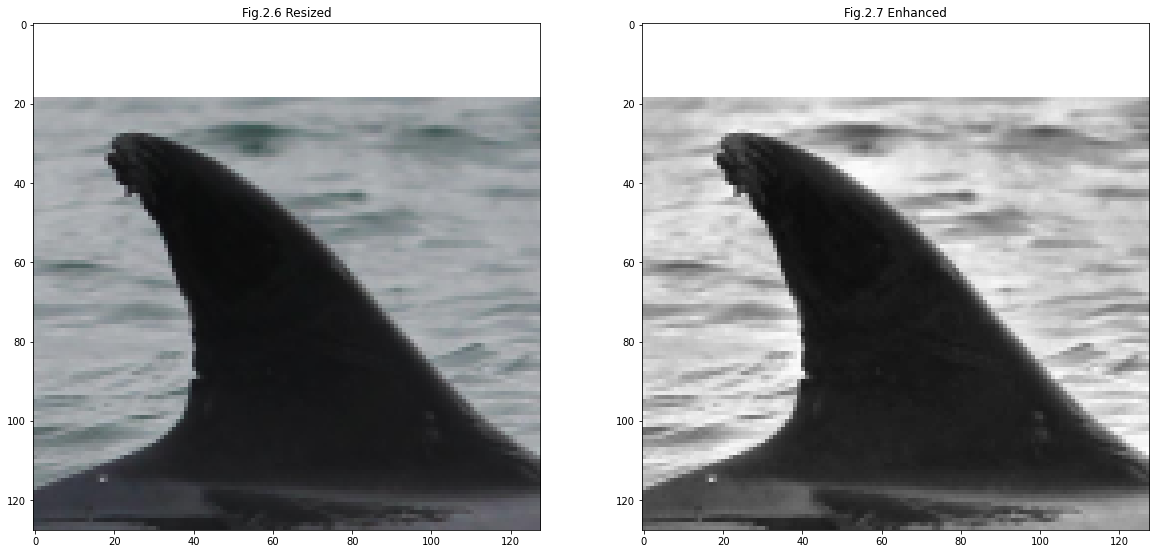

In [17]:
# the first fin from the previous fetching process is taken
image_x = cv2.cvtColor(images[0][0], cv2.COLOR_BGR2BGRA)
img_rsz, image_ftr, img_mask, img_cntr, img_fd, fourier_desc, status = feature_extract(image_x, IMG_SIZE)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_rsz, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.6 Resized");
plt.subplot(122)
plt.imshow(cv2.cvtColor(image_ftr, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.7 Enhanced");

By executing below code one can adjust parameters manually to create a mask for individual matching. A network can be trained based on the enhanced images which can further improve matching of individuals that could not be identified by the automated process.<br>
Any key will terminate the process once started.

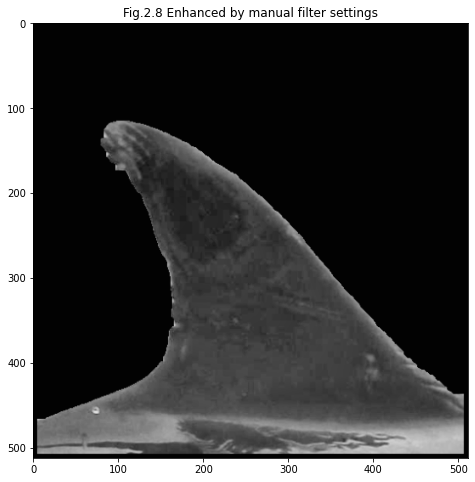

In [14]:
from detect import get_fin

# image = cv2.imread(data_dir+"data/9.jpg")
# img, _ = get_fin(image,0,True)    
cv2.destroyAllWindows() 
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Fig.2.8 Enhanced by manual filter settings");